In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pickle
import math

trunc_normal= tf.truncated_normal_initializer(stddev=0.02)
normal = tf.random_normal_initializer(stddev=0.02)
glorot_normal = tf.glorot_normal_initializer()

from architectures.resDCVAE import *

In [7]:
# some constants

LEARNING_RATE = 0.001
BETA1 = 0.5
BATCH_SIZE = 128
EPOCHS = 5
SAVE_SAMPLE_PERIOD = 428

task='TRAIN'
#task='TEST'
PATH='resDCVAE_test'

In [8]:
global e_sizes, d_sizes


PATH = 'resDCVAE_test'
    
    
e_sizes={

         'conv_layer_0':[(2, 4, 2, False, 1, tf.nn.relu, trunc_normal)],
    
         'convblock_layer_0':[(8, 4, 1, False, 1, tf.nn.relu, trunc_normal),
                              (64, 4, 1, True, 1, tf.nn.relu, trunc_normal)],
         'convblock_shortcut_layer_0':[(64, 1, 1, False, 1, trunc_normal)],
    
         'conv_layer_1':[(128, 4, 2, True, 1, tf.nn.relu, trunc_normal)],
    
         'dense_layers':[(1024 , True, 1, tf.nn.relu, trunc_normal)],
         'z':100
}



            
            
d_sizes={
         'projection':128,
         'bn_after_project':False,
        
         'dense_layers':[(1024, False, 1, tf.nn.relu, trunc_normal)],
    
         'deconv_layer_0':[(128, 4, 2, True, 1, tf.nn.relu, trunc_normal)],
    
         'deconvblock_layer_0':[(64, 4, 1, True, 1, tf.nn.relu, trunc_normal),
                                (8, 4, 1, False, 1, tf.nn.relu, trunc_normal),
                                ],
         'deconvblock_shortcut_layer_0':[(8, 1, 1, False, 1, trunc_normal)],
    
         'deconv_layer_1':[(1, 4, 2, False, 1, tf.sigmoid, trunc_normal)],
}


In [9]:
def mnist():

    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
    
    
    
    X_train = mnist.train.images
    X_train = (X_train>0.5).astype(np.float32)
    X_train = X_train.reshape(X_train.shape[0], 28, 28 ,1)
    
    X_test = mnist.test.images
    X_test = (X_test>0.5).astype(np.float32)
    X_test = X_test.reshape(X_test.shape[0], 28, 28 ,1)
    
    
    n_H = X_train.shape[1]
    n_W = X_train.shape[2]
    n_C = X_train.shape[-1]
    
    
    tf.reset_default_graph()
    vae = resDCVAE(n_H, n_W, n_C, e_sizes, d_sizes,
              lr=LEARNING_RATE, beta1=BETA1,
              batch_size=BATCH_SIZE, epochs=EPOCHS,
              save_sample= SAVE_SAMPLE_PERIOD, path=PATH)
    
    vars_to_train= tf.trainable_variables()
    
    if task == 'TRAIN':
        init_op = tf.global_variables_initializer()
        
    if task == 'TEST':
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        
        sess.run(init_op)

        if task=='TRAIN':
            print('\n Training...')
            
            if os.path.exists(PATH+'/'+PATH+'.ckpt.index'):
                saver.restore(sess,PATH+'/'+PATH+'.ckpt')
                print('Model restored.')
            
            vae.set_session(sess)
            vae.fit(X_train)
            
            save_path = saver.save(sess, PATH+'/'+PATH+'.ckpt')
            print("Model saved in path: %s" % save_path)
        
        if task=='TEST':
            print('\n Evaluate model on test set...')
            saver.restore(sess,PATH+'/'+PATH+'.ckpt')
            print('Model restored.')
            
            vae.set_session(sess)
            
        done = False
        while not done:
            
            i = np.random.choice(len(X_test))
            x = X_test[i].reshape(n_W,n_H,n_C)
            im = vae.posterior_predictive_sample([x]).reshape(n_W,n_H)
            #print('True energy deposit: '+str(np.sum(x))+'\n'+
            #      'HCAL reconstructed energy deposit: '+str(np.sum(reco))+'\n'+
            #      'NN Simulated energy deposit: '+str(np.sum(im)))
            
            plt.subplot(1,2,1)
            
            plt.imshow(x.reshape(
                                n_W,
                                n_H),
                                cmap='gray'
                      )
            plt.title('Original')
            plt.axis('off')
            
            plt.subplot(1,2,2)
            plt.imshow(im, cmap='gray')
            plt.title('Sampled')
            plt.axis('off')
            
            fig = plt.gcf()
            fig.set_size_inches(8, 4)
            plt.savefig(PATH+'/sample_%d.png' % i,dpi=150)
            plt.show()
            

            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

A previous checkpoint already exists, choose the action to perform 
 
 1) Overwrite the current model saved at resDCVAE_test/checkpoint 
 2) Start training a new model 
 3) Restore and continue training the previous model 
 1
Overwriting existing model in resDCVAE_test
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Residual Network architecture detected

 Training...

 ****** 

Training residual convolutional VAE with a total of 55000 samples distributed in batches of size 128

The learning rate set is 0.001, and every 428 iterations a generated sample will be saved to resDCVAE_test

 ****** 

Epoch: 0
At iteration: 428  -  dt: 0:00:41.225558 - cost: -119229.39
Saving a sample...
Epoch: 1
At iteration: 856  -  dt: 0:00:40.964109 - cost: -85293.08
Saving a sample...


/home/cluster/dlanci/anaconda3/envs/deepnet/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Epoch: 2
At iteration: 1284  -  dt: 0:00:40.780754 - cost: -81820.02
Saving a sample...
Epoch: 3
At iteration: 1712  -  dt: 0:00:40.578640 - cost: -83369.84
Saving a sample...
Epoch: 4
At iteration: 2140  -  dt: 0:00:40.372312 - cost: -75817.53
Saving a sample...


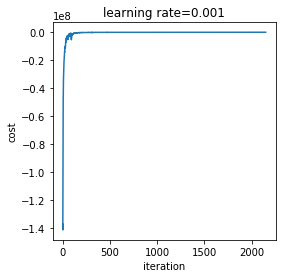

Parameters trained
Model saved in path: resDCVAE_test/resDCVAE_test.ckpt


TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [10]:
if __name__=='__main__':

    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
    
        elif os.path.exists(PATH):
            if os.path.exists(PATH+'/checkpoint'):
                ans = input('A previous checkpoint already exists, choose the action to perform \n \n 1) Overwrite the current model saved at '+PATH+'/checkpoint \n 2) Start training a new model \n 3) Restore and continue training the previous model \n ')
                
                if ans == '1':
                    print('Overwriting existing model in '+PATH)
                    for file in os.listdir(PATH):
                        file_path = os.path.join(PATH, file)
                        try:
                            if os.path.isfile(file_path):
                                os.unlink(file_path)
                            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                        except Exception as e:
                            print(e)
                            
                elif ans == '2':
                    PATH = input('Specify the name of the model, a new directory will be created.\n')
                    os.mkdir(PATH)    
        
        mnist()
   
    elif task == 'TEST': 
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            mnist()